Weight Uncertainty in Neural Networks, Blundell et. al.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import numpy as np
import torch
import time
import math
import experiments.toy_regression as exp

In [2]:
device = torch.device("cpu")

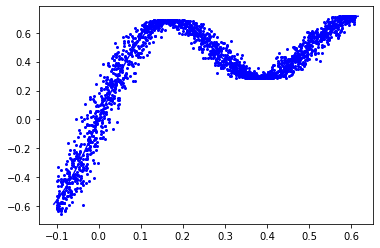

In [3]:
from training import toy
import matplotlib.pyplot as plt

torch.manual_seed(42)

batch_size = 200

trainset = toy.TrigonometricToyDataset(sample_count=2000, noise=0.02, normalize=False, min=-0.1, max=0.61)
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)

axis = plt.subplot()
trainset.plot_dataset(axis)

In [4]:
from training.bbb import MixturePrior

batch_size = 200
noise = torch.tensor(0.02).to(device) # 3, 0.02
layers = [
    ("fc", (1, 16)),
    ("relu", ()),
    ("fc", (16, 16)),
    ("relu", ()),
    ("fc", (16, 16)),
    ("relu", ()),
    ("fc", (16, 1))
]
learn_var = False
prior = MixturePrior(0.25, torch.exp(torch.tensor(-0)), torch.exp(torch.tensor(-6)), validate_args=True)

In [25]:
torch.manual_seed(42)
bbb = exp.bbb(layers, noise, learn_var, 500, trainloader, batch_size, device, layer_samples=1, global_samples=5, prior=prior, sampling="parameters", kl_rescaling=3)

Generated model: Sequential(
  (0): BBBLinear()
  (1): ReLU()
  (2): BBBLinear()
  (3): ReLU()
  (4): BBBLinear()
  (5): ReLU()
  (6): BBBLinear()
)
1186 trainable parameters
Epoch 0: loss 0.7025028467178345
Epoch 10: loss 0.6817817091941833
Epoch 20: loss 0.6741116046905518
Epoch 30: loss 0.6708476543426514
Epoch 40: loss 0.6670714616775513
Epoch 50: loss 0.6662818789482117
Epoch 60: loss 0.664546549320221
Epoch 70: loss 0.6667184233665466
Epoch 80: loss 0.6727734804153442
Epoch 90: loss 0.6650791764259338
Epoch 100: loss 0.6657080054283142
Epoch 110: loss 0.6623244285583496
Epoch 120: loss 0.6640009880065918
Epoch 130: loss 0.6627991199493408
Epoch 140: loss 0.6627355217933655
Epoch 150: loss 0.6646922826766968
Epoch 160: loss 0.6655192971229553
Epoch 170: loss 0.663408637046814
Epoch 180: loss 0.6633070111274719
Epoch 190: loss 0.662979006767273
Epoch 200: loss 0.6625269651412964
Epoch 210: loss 0.6627522110939026
Epoch 220: loss 0.6629995703697205
Epoch 230: loss 0.66420978307724
E

In [ ]:
torch.manual_seed(42)
intel_bbb = exp.intel_bbb(layers, noise, learn_var, 900, trainloader, batch_size)

In [6]:
torch.manual_seed(42)
gp, gp_true_lml = exp.gaussian_process(100, trainset.normalized_xs, trainset.normalized_ys)

Epoch 0: loss 0.7726543545722961
Epoch 20: loss -0.09803839027881622
Epoch 40: loss -0.9700435400009155
Epoch 60: loss -1.2259118556976318
Epoch 80: loss -1.2332895994186401


C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\lazy\lazy_tensor.py:1687: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.. Using symeig method.
  warnings.warn(
C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\chole

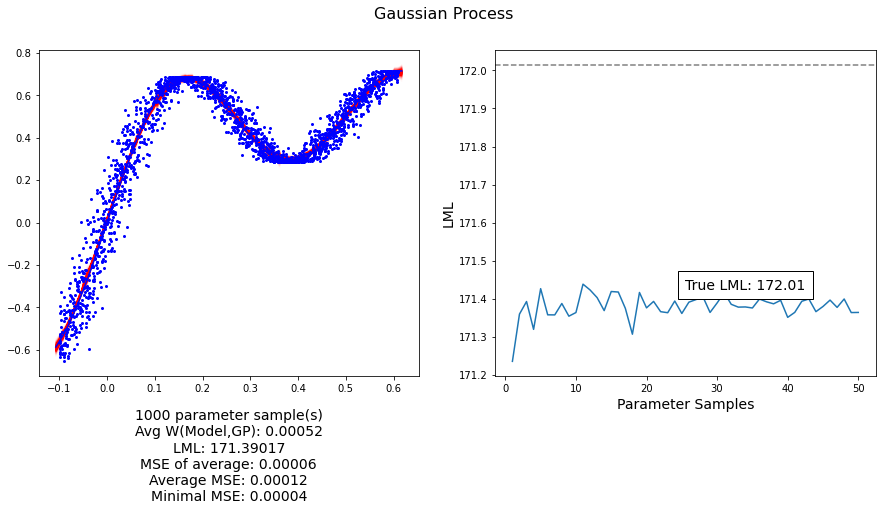

In [7]:
trainset.plot("Gaussian Process", gp, gp, alpha=0.01, samples=1000, plot_lml_trend=(50, 50), gp_lml=gp_true_lml)

C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\lazy\lazy_tensor.py:1687: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.. Using symeig method.
  warnings.warn(


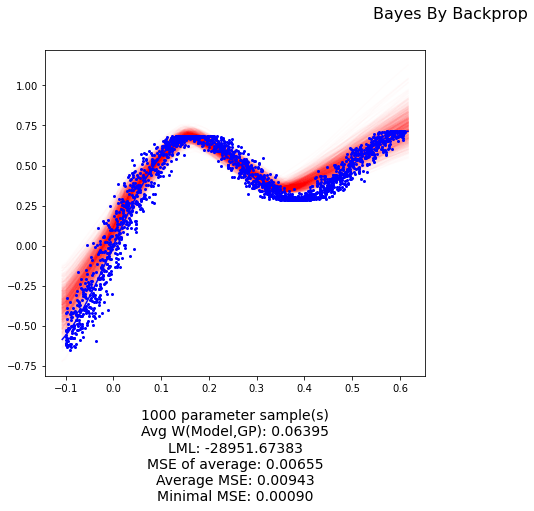

In [26]:
trainset.plot("Bayes By Backprop", bbb, gp, alpha=0.01, samples=1000)

In [18]:
from training.bbb_blundell import BayesianNetwork
torch.manual_seed(0)

def train(net, optimizer, loader):
    #net.train()
    total_loss = torch.tensor(0, dtype=torch.float)

    for (data, target) in loader:
        net.zero_grad()
        x = data.reshape((-1, 1))
        y = target.reshape((-1,1))
        loss = net.BBB_loss(x, y, torch.tensor(0.02).repeat(batch_size))
        total_loss += loss
        loss.backward()
        optimizer.step()
    print(f"Loss: {total_loss / (len(loader) * batch_size)}")

net = BayesianNetwork(inputSize = 1,\
                    CLASSES = 1, \
                    layers=np.array([16,16,16]), \
                    activations = np.array(['relu','relu','relu','none']), \
                    SAMPLES = 5, \
                    BATCH_SIZE = batch_size,\
                    NUM_BATCHES = 2000 / batch_size,\
                    hasScalarMixturePrior = True,\
                    PI = 0.25,\
                    SIGMA_1 = torch.exp(torch.tensor(-0)),\
                    SIGMA_2 = torch.exp(torch.tensor(-6)),\
                    GOOGLE_INIT= False)

optimizer = torch.optim.SGD(net.parameters(),lr=1e-3,momentum=0.95)

for epoch in range(500):
    if (epoch)%10 == 0:
        print('Epoch: ', epoch)
    train(net, optimizer,trainloader)

Epoch:  0
Loss: 0.666766881942749
Loss: 0.6793304085731506
Loss: 0.690872848033905
Loss: 0.6912726759910583
Loss: 0.6955298781394958
Loss: 0.6906027793884277
Loss: 0.6880670785903931
Loss: 0.6858060956001282
Loss: 0.6891757845878601
Loss: 0.6809117794036865
Epoch:  10
Loss: 0.6821401715278625
Loss: 0.6812880635261536
Loss: 0.6777029037475586
Loss: 0.6776310801506042
Loss: 0.68214350938797
Loss: 0.6811498999595642
Loss: 0.6789497137069702
Loss: 0.6767157912254333
Loss: 0.6767832040786743
Loss: 0.6778357028961182
Epoch:  20
Loss: 0.6759957671165466
Loss: 0.6763912439346313
Loss: 0.6747890710830688
Loss: 0.6720196604728699
Loss: 0.6718397736549377
Loss: 0.6719694137573242
Loss: 0.6714837551116943
Loss: 0.6709661483764648
Loss: 0.6694693565368652
Loss: 0.6703019738197327
Epoch:  30
Loss: 0.6701882481575012
Loss: 0.668846845626831
Loss: 0.6691374778747559
Loss: 0.6681644320487976
Loss: 0.6682615280151367
Loss: 0.6668099164962769
Loss: 0.667519211769104
Loss: 0.6692380309104919
Loss: 0.66896

C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\lazy\lazy_tensor.py:1687: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.. Using symeig method.
  warnings.warn(


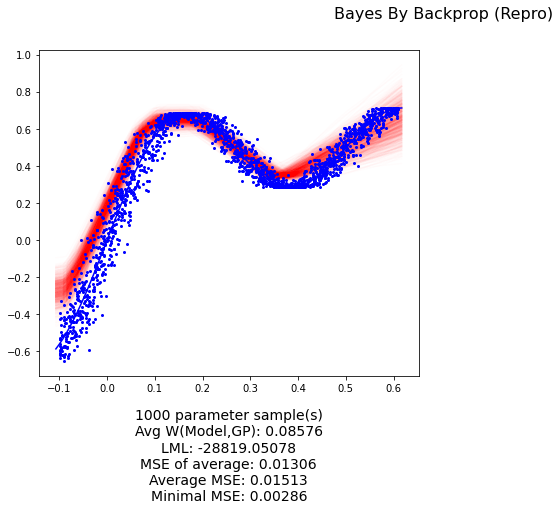

In [20]:
def eval_blundell(input, samples):
    net.eval()
    return [(net(input), torch.tensor(0.02)) for _ in range(samples)]

trainset.plot("Bayes By Backprop (Repro)", eval_blundell, gp, alpha=0.01, samples=1000)